In [ ]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Lenses.lens_pop import LensPop
import numpy as np
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.SourceCatalogues.QuasarCatalog.quasar_pop import QuasarRate
import astropy.coordinates as coord
import astropy.units as u

from slsim.LsstSciencePipeline import opsim_pipeline
from slsim.LsstSciencePipeline.util_lsst import (
    transient_data_with_cadence,
    extract_lightcurves_in_different_bands,
)
from slsim.Plots.plot_functions import plot_lightcurves

## Lensed quasar Lightcurve with survey cadence

This notebook shows how to simulate lensed quasar lightcurves in survey cadence.

In [2]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
galaxy_sky_area = Quantity(value=1, unit="deg2")
quasar_sky_area = Quantity(value=1, unit="deg2")
full_sky_area = Quantity(value=50, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "i", "band_max": 26, "z_min": 0.001, "z_max": 5.0}

## Simulate galaxies

In [3]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None,
    sky_area=galaxy_sky_area,
    filters=["g", "r", "i", "z", "y", "u"],
    cosmo=cosmo,
    z_min=0,
    z_max=4.09,
)

In [4]:
# Initiate deflector popiulation class
lens_galaxies = deflectors.EllipticalLensGalaxies(
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light=None,
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
)

/Users/narayankhadka/slsim/slsim/Deflectors/DeflectorPopulation/elliptical_lens_galaxies.py:48: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  galaxy_list = param_util.catalog_with_angular_size_in_arcsec(


In [5]:
# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 5.01, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)
quasar_source = quasar_class.quasar_sample(m_min=15, m_max=30)

In [6]:
# Prepare dictionary of agn variability kwargs
variable_agn_kwarg_dict = {
    "length_of_light_curve": 500,
    "time_resolution": 1,
    "log_breakpoint_frequency": 1 / 20,
    "low_frequency_slope": 1,
    "high_frequency_slope": 3,
    "standard_deviation": 0.9,
}

kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "g", "r", "i", "z", "y", "u"},
    "agn_driving_variability_model": "bending_power_law",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, 1000, 500),
}
# Initiate source population class.
source_quasar = sources.PointSources(
    quasar_source,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    point_source_type="quasar",
    point_source_kwargs=kwargs_quasar,
)

In [7]:
# Initiate LensPop class to generate lensed quasar pop.
quasar_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

In [8]:
kwargs_lens_cuts = {
    "min_image_separation": 1,
    "max_image_separation": 8,
    "second_brightest_image_cut": {"i": 30},
}
# drawing population
quasar_lens_population = quasar_lens_pop.draw_population(
    speed_factor=100, kwargs_lens_cuts=kwargs_lens_cuts
)

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500


/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

In [9]:
lens_class = quasar_lens_population[0]

## Generate random points on the sky

In [ ]:
# Generate random 10 points in the sky where we will simulate cadence for lsst observation.
# np.random.seed(1)
N = 10
ra_points = coord.Angle(np.random.uniform(low=0, high=360, size=N) * u.degree)
ra_points = ra_points.wrap_at(180 * u.degree)
dec_uniform = np.random.uniform(
    low=np.sin(np.radians(-75)), high=np.sin(np.radians(5)), size=N
)
dec_points = np.degrees(np.arcsin(dec_uniform))
dec_points = coord.Angle(dec_points * u.degree)

## Generate opsim time series data

In [11]:
exposure_data = opsim_pipeline.opsim_time_series_images_data(
    ra_points,
    dec_points,
    "baseline_v3.0_10yrs",
    print_warning=True,
    num_pix=63,
    opsim_path="/Users/narayankhadka/downloads/baseline_v3.4_10yrs.db",
)

Reading from database sqlite:////Users/narayankhadka/downloads/baseline_v3.4_10yrs.db
Read N = 2146797 observations in 157.46 seconds.
No host file.


In [ ]:
# Choose cadence for one of the coordinate point and associated data
transient_data_cadence = exposure_data[9]

In [18]:
# Put a lensed quasar in the chosen cadence
transient_data_with_cadence = transient_data_with_cadence(
    lens_class=lens_class, exposure_data=transient_data_cadence
)

/Users/narayankhadka/slsim/slsim/Util/param_util.py:165: RuntimeWarning: invalid value encountered in log10
  delta_m = -np.log10(amplitude) * 2.5


In [ ]:
# Lightcurves of a chosen lensed quasar with chosen cadence
lightcurves = extract_lightcurves_in_different_bands(transient_data_with_cadence)

## Plot all the extracted lightcurves

/Users/narayankhadka/slsim/slsim/Plots/plot_functions.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


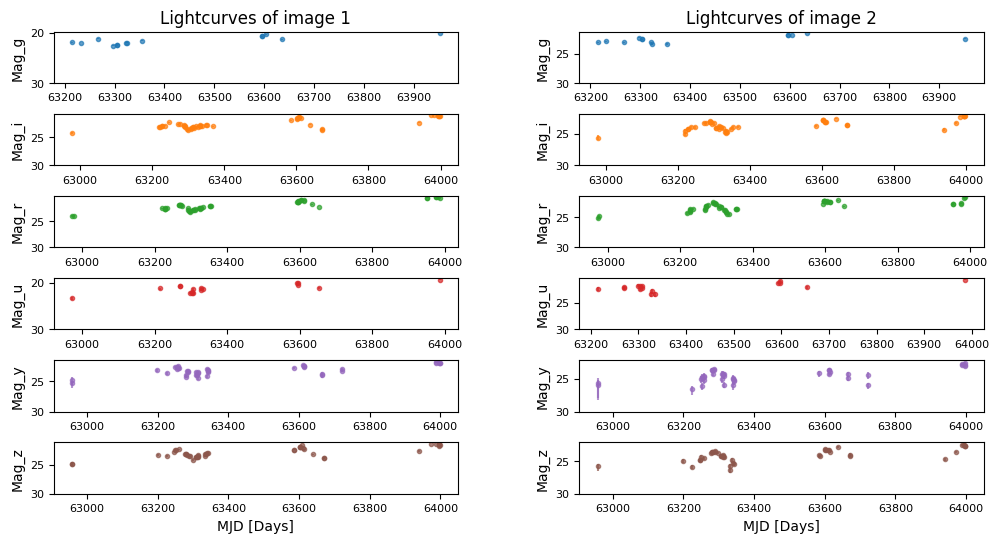

In [22]:
# This function plots all the lightcurves given in the lightcurve dictionary.
# But, one can plot individual lightcurves using their own plotting tools.
plot = plot_lightcurves(lightcurves)